In [53]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [55]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [56]:
import uproot
try:
    aa = uproot.open('root://grid-dcache.physik.rwth-aachen.de:1094////store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/E6694A4B-483C-BB42-AC66-187B1FE69CCF.root')
except Exception as e:
    if isinstance(e, (OSError)):
        print("Shiit")

Shiit


In [57]:
# from coffea import some_test_func

In [58]:
import bokeh
import time
import copy
import scipy.stats as ss
from scipy.optimize import curve_fit
from coffea import hist, processor, nanoevents, util
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoAODSchema, BaseSchema

import awkward as ak
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

from dask.distributed import Client
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl

from pltStyle import pltStyle
import os
# %matplotlib notebook 
# %matplotlib notebook 

### Import processor

In [59]:
from CoffeaJERCProcessor_L5 import Processor

Parameters of the run

In [60]:
UsingDaskExecutor = True
CERNCondorCluster = False
CoffeaCasaEnv     = False
load_preexisting  = False    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False     ### True if run only on one file
load_fit_res      = False

fine_etabins      = False
one_bin           = False

Nfiles = 10

tag = '_L5'

exec('from CoffeaJERCProcessor'+tag+' import Processor') 
add_tag = '_LHEflav1_Herwig-TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
# add_tag='_fine_etaBins'+add_tag
tag_full = tag+add_tag

outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'
outname = outname+'_test' if test_run else outname

# if fine_etabins:
#     tag_full='_oneBin'+tag_full

if one_bin:
    tag_full='_oneBin'+tag_full
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")
    
if test_run:
    Nfiles = 1

In [61]:
# from dask_lxplus import CernCluster
# import socket

# cluster = CernCluster(
#     cores = 1,
#     memory = '500MB',
#     disk = '20MB',
#     death_timeout = '60',
#     lcg = True,
#     nanny = False,
#     container_runtime = 'none',
#     log_directory = '/eos/user/a/anpotreb/condor/log',
#     scheduler_options = {
#         'port': 8788,
#         'host': socket.gethostname(),
#     },
#     job_extra = {
#         'MY.JobFlavour': '"longlunch"',
# #             'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/CoffeaJERCProcessor_L5.py',
#     },
# )

In [62]:
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
# assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'
    
# dataset = 'fileNames/fileNames_QCD20UL18.txt'
# dataset = 'fileNames/fileNames_Herwig_20UL18.txt'
dataset = 'fileNames/fileNames_TTToSemi20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18.txt'
dataset = 'fileNames/fileNames_QCD20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_TTToDilep20UL18_JMENano.txt'
# dataset = 'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_Herwig_20UL18_JMENano.txt'
dataset = 'fileNames/fileNames_TT_Summer16cFlip.txt'

with open(dataset) as f:
    rootfiles = f.read().split()

fileslist = [xrootdstr + file for file in rootfiles]
fileslist = fileslist[:Nfiles] # if add_tag=='QCD' else fileslist # :20 to skim the events

dataset = 'fileNames/fileNames_TTToSemi20UL18_JMENano_redi.txt'

#### dataset with files already with redirectors of the corresponding tiers
with open(dataset) as f:
    rootfiles = f.read().split()
fileslist = rootfiles[:Nfiles]
fileslist = ['root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root', #good file
             'root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root', #bad file
             'root://grid-dcache.physik.rwth-aachen.de:1094////store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/E6694A4B-483C-BB42-AC66-187B1FE69CCF.root' #bad file2
            ] 

print(f'Runing on dataset {dataset}\n Number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}')

Runing on dataset fileNames/fileNames_TTToSemi20UL18_JMENano_redi.txt
 Number of files: 10
 Job with the full tag _L5_LHEflav1_Herwig-TTBAR-JME
 Outname = out/CoffeaJERCOutputs_L5_LHEflav1_Herwig-TTBAR-JME.coffea


In [63]:
def find_xsec(key):
    semilepxsec = 0.108*3*0.337*2*2
    dilepxsec = 0.108*3*0.108*3
    hadxsec = 0.337*2*0.337*2

    if "TTToSemi" in key:
        xsec = semilepxsec
    elif "TTToDilep" in key:
        xsec = dilepxsec
    elif "TTToHad" in key:
        xsec = hadxsec
    else:
        xsec = 1
    return xsec

xsec = find_xsec(dataset)

In [64]:
combineTTbar = False

# datasets = ['fileNames/fileNames_TTToSemi20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToDilep20UL18_JMENano.txt',
#            'fileNames/fileNames_TTToHad20UL18_JMENano.txt'
#            ]
file_tags = ['Semi', 'Dilep', 'Had']

filesets = {}
if combineTTbar:
    for ftag in file_tags:
        data_name = f'fileNames/fileNames_TTTo{ftag}20UL18_JMENano.txt'
        with open(data_name) as f:
            rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
        fileslist = fileslist[:Nfiles]
        xsec = find_xsec(data_name)
        filesets[ftag] = {"files": fileslist, "metadata": {"xsec": xsec}}
else:
    filesets = {'QCD': {"files": fileslist, "metadata": {"xsec": xsec}}}
# fileslist = fileslist
# if test_run:
#     fileslist = [fileslist[1]]

Test if certificate works to open the file

In [65]:
import os
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [66]:
import uproot

In [67]:
# ff = uproot.open(fileslist[0])
# ff.keys()
# ff.close()

# Dask Setup:
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


In [68]:
# ak.type(light_match_candidates.pt)
# bla.pdgId

In [69]:
# Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [70]:
# import logging
# logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.WARNING)

In [71]:
# X509_CERT_DIR = 

In [72]:
env_extra = [
            'export XRD_RUNFORKHANDLER=1',
            f'export X509_USER_PROXY=/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem',
            f'export X509_CERT_DIR={os.environ["X509_CERT_DIR"]}',
#             'source /etc/profile.d/conda.sh',
#             f'export PATH={os.environ["CONDA_PREFIX"]}/bin:$PATH',
#             f'conda activate {os.environ["CONDA_DEFAULT_ENV"]}',
        ]

In [73]:
# import uproot
# fii = '/store/mc/RunIISummer20UL18NanoAODv9/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2430000/C130FB11-7A37-6E49-9549-3FDAD96BCD76.root'
# # xrootdstr = 'root://cmsxrootd.fnal.gov/'
# # assume running on the lxplus
# # xrootdstr = 'root://cms-xrd-global.cern.ch//'
# xrootdstr = 'root://xrootd-cms.infn.it//'
# filee = xrootdstr + fii
# ff = uproot.open(filee)


In [74]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
# Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
            env_extra=env_extra,
            cores = 4,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
                'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=50)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag+'.py')

    client

{'scheduler': {'host': {'python': '3.9.12.final.0',
   'python-bits': 64,
   'OS': 'Linux',
   'OS-release': '3.10.0-1160.80.1.el7.x86_64',
   'machine': 'x86_64',
   'processor': 'x86_64',
   'byteorder': 'little',
   'LC_ALL': 'None',
   'LANG': 'en_US.UTF-8'},
  'packages': {'python': '3.9.12.final.0',
   'dask': '2022.6.1',
   'distributed': '2022.6.1',
   'msgpack': '0.6.1',
   'cloudpickle': '1.6.0',
   'tornado': '6.1',
   'toolz': '0.11.2',
   'numpy': '1.22.3',
   'pandas': '1.2.2',
   'lz4': '4.0.0'}},
 'workers': {'tcp://127.0.0.1:35018': {'host': {'python': '3.9.12.final.0',
    'python-bits': 64,
    'OS': 'Linux',
    'OS-release': '3.10.0-1160.80.1.el7.x86_64',
    'machine': 'x86_64',
    'processor': 'x86_64',
    'byteorder': 'little',
    'LC_ALL': 'None',
    'LANG': 'en_US.UTF-8'},
   'packages': {'python': '3.9.12.final.0',
    'dask': '2022.6.1',
    'distributed': '2022.6.1',
    'msgpack': '0.6.1',
    'cloudpickle': '1.6.0',
    'tornado': '6.1',
    'toolz': 

{'tcp://127.0.0.1:35018': {'status': 'OK'},
 'tcp://127.0.0.1:36328': {'status': 'OK'},
 'tcp://127.0.0.1:37643': {'status': 'OK'},
 'tcp://127.0.0.1:40031': {'status': 'OK'},
 'tcp://127.0.0.1:41752': {'status': 'OK'}}

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 28.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46169,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 28.60 GiB
Comm: tcp://127.0.0.1:37643,Total threads: 2
Dashboard: http://127.0.0.1:41117/status,Memory: 5.72 GiB
Nanny: tcp://127.0.0.1:34458,


In [75]:
# import re
# import sys
# aa = re.match('^/cvmfs/sft(?:-nightlies)?.cern.ch/lcg+/python[2,3]?$', sys.executable)

In [76]:
# sys.executable

In [77]:
# import sys
# import re
# if not re.match('^/cvmfs/sft(?:-nightlies)?.cern.ch/lcg/latest/.+/python[2,3]?$', sys.executable):
#     "print"
# sys.executable

In [78]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 5] # [chunksize, maxchunks]

# filedict = {f"MC": {"files": fileslist, "metadata": {"xsec": xsec}}}
# filesets = {'QCD': {"files": fileslist, "metadata": {"xsec": xsec}}}

if not load_preexisting:
#     for name,files in filesets.items(): 
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job({'QCD':filesets},
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 6,
#                                               'workers': 2
                                          },
                                          chunksize=Chunk[0])#, maxchunks=Chunk[1])

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)
   

if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

evaluator =  <coffea.lookup_tools.evaluator.evaluator object at 0x7f73aefa7f70>
evaluator keys =  dict_keys(['Summer20UL18_V2_MC_L1FastJet_AK4PFchs', 'Summer20UL18_V2_MC_L2Relative_AK4PFchs', 'Summer20UL18_V2_MC_L3Absolute_AK4PFchs'])
[#############                           ] | 33% Completed |  1.9s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:983: UserWarning: file not found ([ERROR] Server responded with an error: [3012] Failed to open file (Unit not found : SE [128])
)

    'root://grid-dcache.physik.rwth-aachen.de:1094////store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/E6694A4B-483C-BB42-AC66-187B1FE69CCF.root'

Files may be specified as:
   * str/bytes: relative or absolute filesystem path or URL, without any colons
         other than Windows drive letter or URL schema.
         Examples: "rel/file.root", "C:\abs\file.root", "http://where/what.root"
   * str/bytes: same with an object-within-ROOT path, separated by a colon.
         Example: "rel/file.root:tdirectory/ttree"
   * pathlib.Path: always interpreted as a filesystem path or URL only (no
         object-within-ROOT path), regardless of whether there are any colons.
        

[#                                       ] | 4% Completed |  1.9s0s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))


[######                                  ] | 15% Completed |  2.6s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))


[###################                     ] | 48% Completed | 14.9s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))


[####################                    ] | 50% Completed | 15.2s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))


[######################                  ] | 55% Completed | 22.0s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Invalid redirect URL
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/230000/55E72333-8846-D040-90FF-266FCA3EF67B.root
  warnings.warn(str(e))


[############################            ] | 70% Completed |  1min  0.4s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Operation expired
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root
  warnings.warn(str(e))
/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Operation expired
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root
  warnings.warn(str(e))


[####################################    ] | 92% Completed |  2min  0.4s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Operation expired
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root
  warnings.warn(str(e))


[######################################  ] | 96% Completed |  2min 52.5s

/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/coffea/processor/executor.py:986: UserWarning: XRootD error: [ERROR] Operation expired
in file root://cms-xrd-global.cern.ch///store/mc/RunIISummer16NanoAODv7/TT_TuneCUETP8M2T4_13TeV-powheg-colourFlip-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8_ext1-v1/20000/8033E2A6-04CC-2A4B-9636-BF2A51214156.root
  warnings.warn(str(e))


Processor finished. Time elapsed:  183.5313904285431mpleted |  3min  0.3s
Saving the output histograms under:  out/CoffeaJERCOutputs_L5_LHEflav1_Herwig-TTBAR-JME.coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea
Printing stuff from coffea


In [80]:
import sys

In [79]:
output

{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f733cca7280>,
 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09dc0>,
 'ptresponse_u': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f093d0>,
 'ptresponse_d': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09d30>,
 'ptresponse_s': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09280>,
 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f090a0>,
 'ptresponse_bbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f093a0>,
 'ptresponse_cbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09070>,
 'ptresponse_ubar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09e50>,
 'ptresponse_dbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09340>,
 'ptresponse_sbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316f09fa0>,
 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f7316

In [66]:
output

{'ptresponse_b': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e466b9460>,
 'ptresponse_c': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e256523a0>,
 'ptresponse_u': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a2b0>,
 'ptresponse_d': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a280>,
 'ptresponse_s': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a4c0>,
 'ptresponse_g': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a130>,
 'ptresponse_bbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a5b0>,
 'ptresponse_cbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a7f0>,
 'ptresponse_ubar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a4f0>,
 'ptresponse_dbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a640>,
 'ptresponse_sbar': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e2567a850>,
 'ptresponse': <Hist (dataset,pt,jeteta,ptresponse) instance at 0x7f2e25

In [65]:
output['ptresponse_b'].values()[('QCD',)].sum()

195625.0

In [80]:
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

### Fit responses

define gaussian function for fitting the responses

In [209]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Define some global variables for the fit

In [210]:
f_xvals = np.linspace(0,5,5001)
# fine_etabins = False

if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output['ptresponse'].axis('pt').edges()
    ptbins_c = output['ptresponse'].axis('pt').centers()
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])

    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_mod = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_mod[:-1]+etabins_mod[1:])/2 #output['ptresponse'].axis('jeteta').centers()

ptresp_edd = output['ptresponse'].axis('ptresponse').edges()
plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To exclude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

In [211]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

### Testing adding hists

In [212]:
# combineTTbar = False
# if combineTTbar==True:
#     N_evts_had = 41113000
#     N_evts_semilep = 48065000
#     N_evts_dilep = 41160000

#     N_evts = np.array([N_evts_had, N_evts_semilep, N_evts_dilep])

#     N_av = (N_evts_had+N_evts_semilep+N_evts_dilep)/3

#     semilepxsec = 0.108*3*0.337*2*2
#     dilepxsec = 0.108*3*0.108*3
#     hadxsec = 0.337*2*0.337*2

#     xsec = np.array([hadxsec, semilepxsec, dilepxsec])
#     weights = N_evts/N_av*xsec

#     # (N_evts/N_av*xsec).sum()

#     add_tags = ['_LHEflav1_TTBAR-Had-JME', '_LHEflav1_TTBAR-JME', '_LHEflav1_TTBAR-Dilep-JME']
#     tag_fulls = [tag+addtag for addtag in add_tags]
#     outnames = ['out/CoffeaJERCOutputs'+tag_full+'.coffea' for tag_full in tag_fulls]

#     outputs = [util.load(outname) for outname in outnames]
    
#     tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [213]:
# combineTTbar = False
if combineTTbar:
    ids = output[list(output.keys())[0]].axis('dataset').identifiers()
    names = [idii.name for idii in ids  ]

    output_comb = {}

    N = {}
    for s in names:
        N[s] = output['cutflow'][s+': all events']
    N_av = sum(N.values())/3

    for key in output.keys():
        if key!='cutflow':
            hist_comb = output[key].integrate('dataset', ids[0])
            hist_comb.scale(find_xsec(names[0])*N[names[0]]/N_av)
            for ii in range(1,len(ids)-1):
                hist2 = output[key].integrate('dataset', ids[ii])
                hist2.scale(find_xsec(ids[ii].name)*N[names[ii]]/N_av)
                hist_comb = hist_comb+hist2
            output_comb[key] = hist_comb
        else:
            cut_keys = list(output[key].keys())
            len_new_keys = len(cut_keys)//3
            output_comb["cutflow"] = {}
            for cut in range(len_new_keys):
                output_comb["cutflow"]["Inclusive"+cut_keys[cut][4:]] = (output[key][cut_keys[cut]]*find_xsec(names[0])*N[names[0]]/N_av +
                                                               output[key][cut_keys[cut+len_new_keys]]*find_xsec(names[1])*N[names[1]]/N_av +
                                                               output[key][cut_keys[cut+2*len_new_keys]]*find_xsec(names[2])*N[names[2]]/N_av 
                                                              )
                
    output = output_comb
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [214]:
# if combineTTbar:
#     histoMi = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#     histoPl = outputs[0]['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#     histo = (histoMi+histoPl)
#     histo.values()[('QCD',)][1:10] 
#     histo.scale(weights[0])
    
#     histo.values()[('QCD',)][1:10] 
    

#     for out, wg in zip(outputs[1:], weights[1:]):
#         histoMi = out['ptresponse'+samp].integrate('jeteta', etaBinMi).integrate('pt', ptBin).copy()
#         histoPl = out['ptresponse'+samp].integrate('jeteta', etaBinPl).integrate('pt', ptBin).copy()
#         histo2 = histoMi+histoPl
#         histo2.scale(wg)
#         histo2.values()[('QCD',)][1:10]
#         histo.add(histo2)
        
#     histo.values()[('QCD',)][1:10]

In [215]:
# for samp in subsamples:
#     if combine_antiflavour and (samp in barable_samples):
#         comb = True

#     if combineTTbar:
#         if comb==True:
            
        
#     else:
#         if comb==True:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
#         else:
#             output_hist['ptresponse'+samp] = output['ptresponse'+samp]


In [216]:
# combine_antiflavour = True

In [217]:
def get_median(yvals, bin_edges):
    yvals_cumsum = np.cumsum(yvals)
    N = np.sum(yvals)
    med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
    
    median = bin_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(bin_edges[med_bin+1]
                                                                                 - bin_edges[med_bin])
    return median

In [218]:
# response_hist = output['ptresponse'+'_b']

# k=0
# etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
# etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
# i=14
# ptBin = hist.Interval(ptbins[i], ptbins[i+1])

# dataset_name = list(histo.values().keys())[0]
# histoMi = response_hist.integrate('jeteta', etaBinMi).integrate('pt', ptBin)
# histoPl = response_hist.integrate('jeteta', etaBinPl).integrate('pt', ptBin)
# histo = (histoMi+histoPl)
# N = histo.integrate('ptresponse').values()[dataset_name]-histo.values()[dataset_name][0]

# yvals = histo.values()[dataset_name][1:]
# yvals_cumsum = np.cumsum(yvals)

In [219]:
# xvals = response_hist.axis('ptresponse').centers()[1:]

# hist_mean = np.sum(xvals*yvals)/sum(yvals) 
# hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
# medianstd = 1.253 * hist_rms/np.sqrt(N)

In [220]:
# med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
# response_edges = response_hist.axis('ptresponse').edges()[1:]
# median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
#                                                                                       - response_edges[med_bin])

In [221]:
# median
# hist_mean

In [222]:
# N
# np.sum(yvals)

In [223]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad
barable_samples = ['_b', '_c', '_s', '_u', '_d']

def fit_responses(output, samp='_b'):
    warnings.filterwarnings('ignore')
    
    if combine_antiflavour and (samp in barable_samples):
        response_hist = output['ptresponse'+samp] + output['ptresponse'+samp+'bar']
    else:
        response_hist = output['ptresponse'+samp]

    mean = np.zeros((jetpt_length, jeteta_length))
    medians = np.zeros((jetpt_length, jeteta_length))
    medianstds = np.zeros((jetpt_length, jeteta_length))
    width = np.zeros((jetpt_length, jeteta_length))
#     chi2s = np.zeros((jetpt_length, jeteta_length))
    meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []
    
    N_converge = 0
    N_not_converge = 0

    FitFigDir = 'fig/response_pt_eta'+samp+tag_full
    print("Images will be saved under ", FitFigDir)
    if not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        
    xvals = response_hist.axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
    f_xvals = np.linspace(0,max(xvals),5001)
    response_edges = response_hist.axis('ptresponse').edges()[1:]

    for i in range(jetpt_length):
        ptBin = hist.Interval(ptbins[i], ptbins[i+1])
#         print('-'*25)
#         print('-'*25)
        
        if not 'inf' in str(ptBin):
            pt_string = '_pT'+str(int(ptBin.lo))+'to'+str(int(ptBin.hi))
        else:
            pt_string = '_pT'+str(ptBin.lo) + 'to' + str(ptBin.hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            etaBinPl = hist.Interval(etabins[k+jeteta_length], etabins[k+1+jeteta_length])
            etaBinMi = hist.Interval(etabins[jeteta_length-k-1], etabins[jeteta_length-k])
#             etaBin = hist.Interval(etabins[k], etabins[k+1])
#             print("etaBin = ", etaBinPl ,", ptBin = ", ptBin )
            eta_string = '_eta'+str(etaBinPl.lo)+'to'+str(etaBinPl.hi)
            eta_string = eta_string.replace('.','')
            
            # The name integrate is a bit misleasding in this line. Is there another way to "slice" a histogram? //Andris
            histoMi = response_hist.integrate('jeteta', etaBinMi).integrate('pt', ptBin)
            histoPl = response_hist.integrate('jeteta', etaBinPl).integrate('pt', ptBin)
            histo = (histoMi+histoPl)
                
            dataset_name = list(histo.values().keys())[0]
#             output_comb['ptresponse_b'].values()[dataset_name]
            yvals = histo.values()[dataset_name][1:]  #[1:] to exclude the second peak for low pt

            N = np.sum(yvals)
#             N = histo.integrate('ptresponse').values()[dataset_name]-histo.values()[dataset_name][0]
            
           ####################### Calculate median and rms ############################
            
            yvals_cumsum = np.cumsum(yvals)
#             "yvals cumsum"
#             print(yvals_cumsum)
#             print("N = ", N)
#             print("yvals = ", yvals)
#             print("np.nonzero(yvals_cumsum>N/2) = ", np.nonzero(yvals_cumsum>N/2))
               # For N<200 too little statistics to calculate the error resonably
            med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>200 else 0
            median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                                      - response_edges[med_bin])
            
            hist_mean = np.sum(xvals*yvals)/sum(yvals) 
            hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
            medianstd = 1.253 * hist_rms/np.sqrt(N)
            
           ####################### Fitting ############################
            nonzero_bins = np.sum(yvals>0)
            if nonzero_bins<2 or N<50:
                p2=[0,0,0]
                chi2 = np.nan
                arr = np.array([[np.nan]*3]*3)
                Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
            else:
                try:
                    p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
                    N_converge += 1
                         ######## Second Gaussian ########
                    xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
                    xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
                    xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)
                    
                    if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
                        xfit_l = xfit_l-1
                        xfit_h = xfit_h+1
                        if len(range(xfit_l,xfit_h))<6:
                            xfit_l = xfit_l-1
                            xfit_h = xfit_h+1
                    if xfit_l<0:
                        xfit_h-=xfit_l
                        xfit_l = 0
                    xvals2 = xvals[xfit_l: xfit_h]
                    yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
                    p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

                    ygaus = gauss(xvals, *p2)
                    chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
                    Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
                except(RuntimeError):
                    p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
                    chi2 = np.nan
                    arr = np.array([[np.nan]*3]*3)
                    Ndof = 0
                    N_not_converge += 1
                    continue


            fgaus2 = gauss(f_xvals, *p2)

            width_ik = np.abs(p2[2])
            
            mean[i,k] = p2[1]
            meanvar[i,k] = arr[1,1]
            medians[i,k] = median
            medianstds[i,k] = medianstd
            width[i,k] = width_ik
#             chi2s[i,k] = chi2

   ####################### Plotting ############################
#             if not os.path.exists('test/'+FitFigDir):
#                 os.mkdir('test/'+FitFigDir)
#             histo = histo.rebin('ptresponse', plot_response_axis)

#             fig, ax2 = plt.subplots();
#             hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
#                         fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
#             # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
#             ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
#             ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
#             ax2.set_xlim(plot_pt_edges[[0,-1]])
#             h = ax2.get_ylim()[1]/1.05
#             plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
#             plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
#             plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
#             plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
#             plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
#             ax2.legend();

#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('test/'+FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.close();   

        if not test_run and (not fine_etabins) and True:
                histo = histo.rebin('ptresponse', plot_response_axis)

                fig, ax2 = plt.subplots();
                hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
                            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
                # ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
                ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
                ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
                ax2.set_xlim(plot_pt_edges[[0,-1]])
                h = ax2.get_ylim()[1]/1.05
                plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
                plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
                plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
                plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
                plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
                ax2.legend();

#                 plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#                 plt.savefig(FitFigDir+'/ptResponse'+pt_string+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
                plt.close();                

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return [mean, meanvar, medians, medianstds] #width, 
    

In [224]:
np.array([1,2,3])*np.array([2,3,5])

array([ 2,  6, 15])

In [225]:
def plot_corrections(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
    start = np.searchsorted(ptbins_c, 20, side='left') #np.where(ptbins<=20)[0][-1]
    
    k2 = np.where(etabins_mod<=0)[0][-1]
    k4 = np.where(etabins_mod<=1.3)[0][-1]
    k6 = np.where(etabins_mod<=2.5)[0][-1]
    k8 = np.where(etabins_mod<=3.0)[0][-1]
    lastbin = np.where(~ np.isnan(mean_p[:, k2]*mean_p[:, k4]*mean_p[:, k6]*mean_p[:, k8]))[0][-1]
    
    ptbins_plot = ptbins_c[start:lastbin]
    meanstd = meanstd[start:lastbin,:]
    
    mean_p = mean_p[start:lastbin]
    
    plt.errorbar(ptbins_plot, mean_p[:,k2], yerr=meanstd[:,k2], marker='o',
                 linestyle="none", label=f'{etabins_mod[k2]}'+r'$<\eta<$'+f'{etabins_mod[k2+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k4], yerr=meanstd[:,k4], marker='o',
             linestyle="none", label=f'{etabins_mod[k4]}'+r'$<\eta<$'+f'{etabins_mod[k4+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k6], yerr=meanstd[:,k6], marker='o',
             linestyle="none", label=f'{etabins_mod[k6]}'+r'$<\eta<$'+f'{etabins_mod[k6+1]}')
    plt.errorbar(ptbins_plot, mean_p[:,k8], yerr=meanstd[:,k8], marker='o',
             linestyle="none", label=f'{etabins_mod[k8]}'+r'$<\eta<$'+f'{etabins_mod[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([meanstd[:,[k2, k4, k6, k8]] ])
    y_norm = np.concatenate([mean_p[:,[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    
    left_lim = np.min((y_norm-yerr_norm)[norm_pos])
    right_lim = np.max((yerr_norm+y_norm)[norm_pos])
    lim_pad = (right_lim - left_lim)/20
    ax.set_ylim(left_lim-lim_pad, right_lim+lim_pad)
#     ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    
    ax.set_xscale('log')
    
    
    
    good_xlims = ax.get_xlim()
    ax.set_xticks([20, 50, 100, 500, 1000, 5000])
    ax.set_xlim(good_xlims)
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'median response');
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_pt'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_pt'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [226]:
def plot_corrections_eta(mean, samp, meanstd):
    ### To ignore the points with 0 on y axis when setting the y axis limits
    mean_p = mean.copy()
    mean_p[mean_p==0] = np.nan

    fig, ax = plt.subplots()
#     start = np.where(ptbins<=20)[0][-1]
    
#     ptbins_plot = ptbins_c[start:]
#     meanstd = meanstd[start:,:]
#     mean_p = mean_p[start:]
    
    k2 = np.where(ptbins<=15)[0][-1]
    k4 = np.where(ptbins<=40)[0][-1]
    k6 = np.where(ptbins<=150)[0][-1]
    k8 = np.where(ptbins<=400)[0][-1]
    
#     np.isnan(mean_p[k2,:]*mean_p[k4,:]*mean_p[k6,:]*mean_p[k8,:])
    
    plt.errorbar(etabins_c, mean_p[k2,:], yerr=meanstd[k2], marker='o',
                 linestyle="none", label=f'{ptbins[k2]}'+r'$<p_t<$'+f'{ptbins[k2+1]}')
    plt.errorbar(etabins_c, mean_p[k4,:], yerr=meanstd[k4], marker='o',
             linestyle="none", label=f'{ptbins[k4]}'+r'$<p_t<$'+f'{ptbins[k4+1]}')
    plt.errorbar(etabins_c, mean_p[k6], yerr=meanstd[k6], marker='o',
             linestyle="none", label=f'{ptbins[k6]}'+r'$<p_t<$'+f'{ptbins[k6+1]}')
    plt.errorbar(etabins_c, mean_p[k8], yerr=meanstd[k8], marker='o',
             linestyle="none", label=f'{ptbins[k8]}'+r'$<p_t<$'+f'{ptbins[k8+1]}')

    ### Calculate resonable limits excluding the few points with insane errors
    yerr_norm = np.concatenate([np.sqrt(meanvar[[k2, k4, k6, k8]]) ])
    y_norm = np.concatenate([mean_p[[k2, k4, k6, k8]]])
    norm_pos = (yerr_norm<0.02) &  (yerr_norm != np.inf) & (y_norm>-0.1)
    ax.set_ylim(np.min((y_norm-yerr_norm)[norm_pos]) ,np.max((yerr_norm+y_norm)[norm_pos]))
    ax.set_xlabel(r'$\eta$');
    ax.set_ylabel(r'median response');
#     ax.set_xscale('log')
    ax.legend()
    if test_run:
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        plt.savefig('test/fig/corr_vs_eta'+samp+tag_full+'_test.png', dpi=plt.rcParamsDefault['figure.dpi']);
    else:
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.pdf');
        plt.savefig('fig/corr_vs_eta'+samp+tag_full+'.png');

    plt.show();
    
# plotCorrections()

In [227]:
def save_data(data, name, samp):
    # data = {str(ptBin):mean[i] for i, ptBin in enumerate(output['jetpt'].axis('pt')[1:-1])}
    data_dict = {str(ptBin):data[i] for i, ptBin in enumerate(ptbins[:-1])}

    # data['etaBins'] = [str(etaBin) for etaBin in output['jeteta'].axis('jeteta')[1:-1]]
    data_dict['etaBins'] = np.array([str(etaBin) for etaBin in etabins_mod[:-1]])

    df = pd.DataFrame(data=data_dict)
    df = df.set_index('etaBins')
    if not test_run:
        df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else:
        df.to_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv')
#     return df

In [228]:
def read_data(name, samp):
    if not test_run:
        df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'.csv')
    else: #before_closure/
        df_csv = pd.read_csv('test/out_txt/EtaBinsvsPtBins'+name+samp+tag_full+'_test.csv').set_index('etaBins')
#         df.to_csv('out_txt/EtaBinsvsPtBins'+name+tag+'_test.csv')
    
#     df_csv = pd.read_csv('out_txt/EtaBinsvsPtBinsMean_L5.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Run fitting for each sample

In [229]:
medians = []
medianstds = []

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/response_pt_eta_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  68 N_not_converge =  0


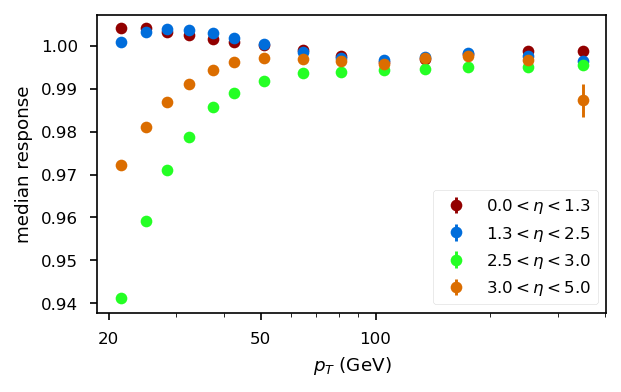

-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/response_pt_eta_b_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  62 N_not_converge =  0


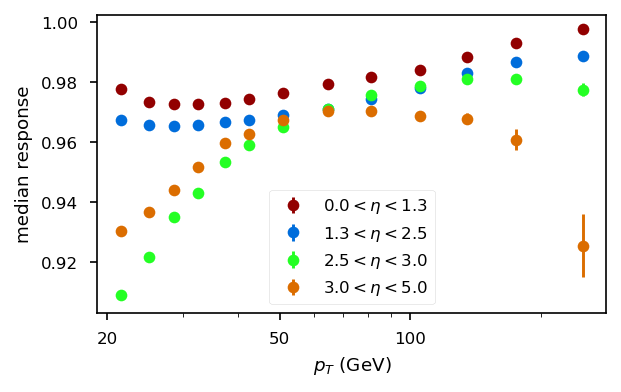

-------------------------
-------------------------
Fitting subsample:  _c
Images will be saved under  fig/response_pt_eta_c_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  62 N_not_converge =  0


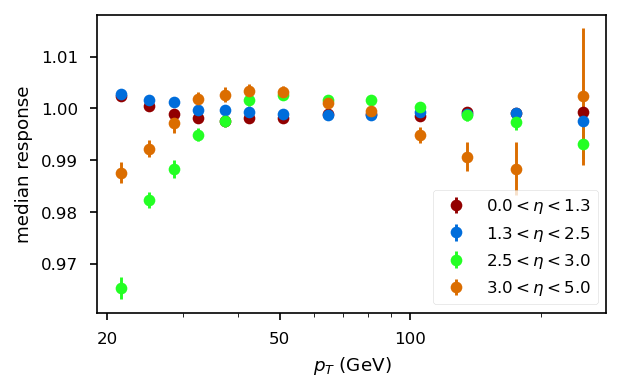

-------------------------
-------------------------
Fitting subsample:  _u
Images will be saved under  fig/response_pt_eta_u_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  64 N_not_converge =  0


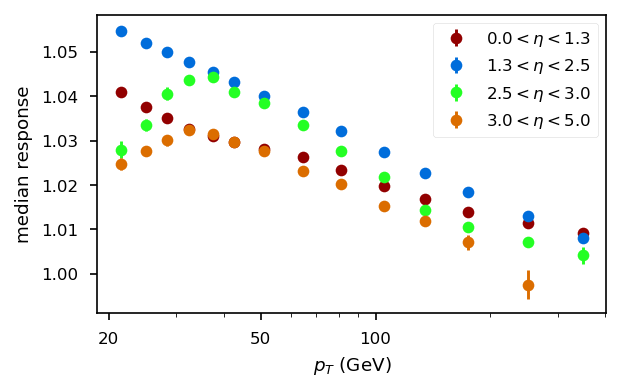

-------------------------
-------------------------
Fitting subsample:  _d
Images will be saved under  fig/response_pt_eta_d_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  67 N_not_converge =  0


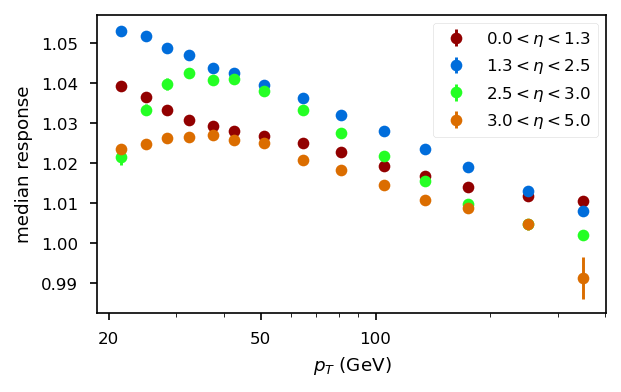

-------------------------
-------------------------
Fitting subsample:  _s
Images will be saved under  fig/response_pt_eta_s_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  62 N_not_converge =  0


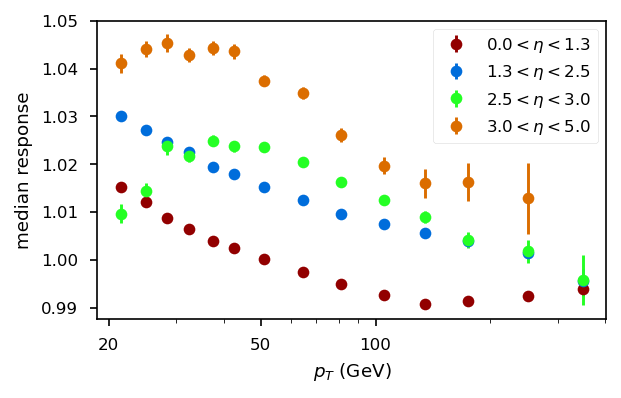

-------------------------
-------------------------
Fitting subsample:  _g
Images will be saved under  fig/response_pt_eta_g_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  64 N_not_converge =  0


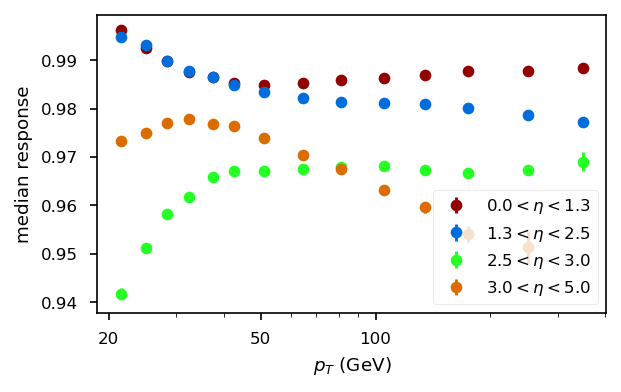

-------------------------
-------------------------
Fitting subsample:  _bbar
Images will be saved under  fig/response_pt_eta_bbar_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  62 N_not_converge =  0


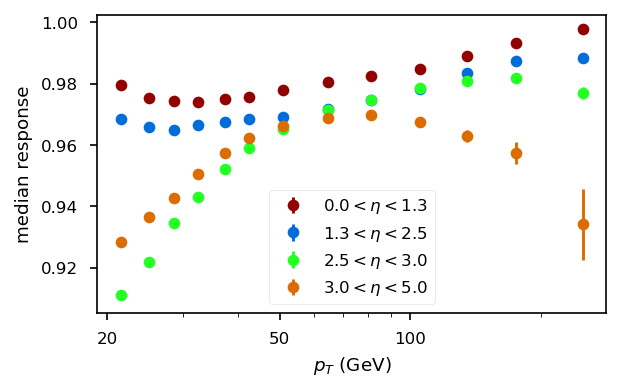

-------------------------
-------------------------
Fitting subsample:  _cbar
Images will be saved under  fig/response_pt_eta_cbar_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  60 N_not_converge =  0


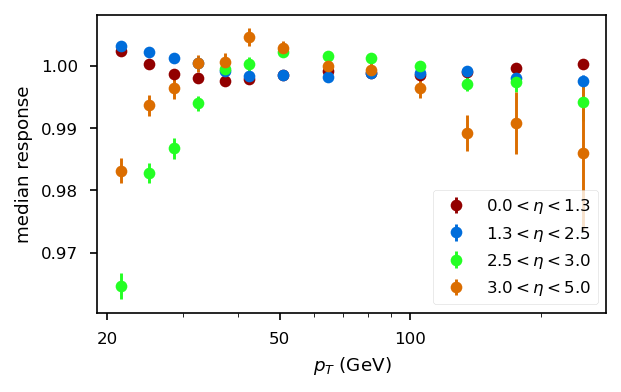

-------------------------
-------------------------
Fitting subsample:  _ubar
Images will be saved under  fig/response_pt_eta_ubar_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  64 N_not_converge =  0


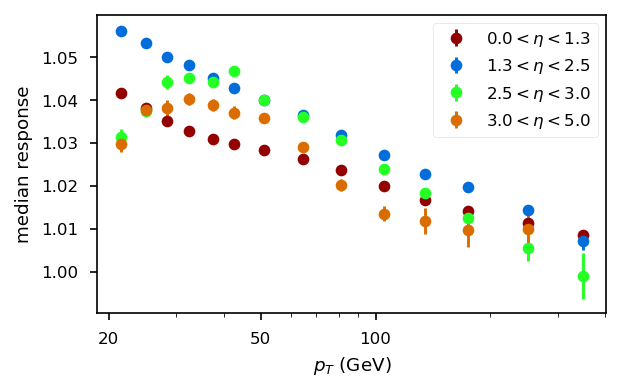

-------------------------
-------------------------
Fitting subsample:  _dbar
Images will be saved under  fig/response_pt_eta_dbar_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  61 N_not_converge =  0


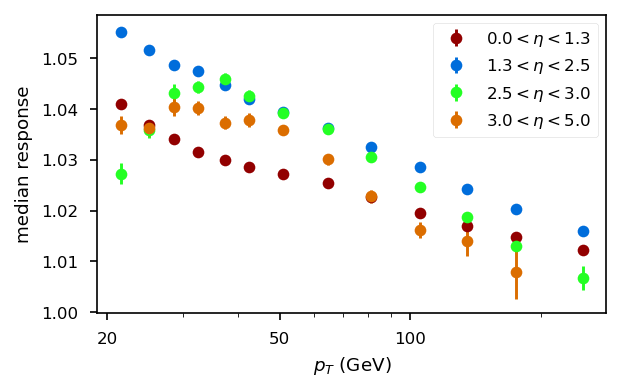

-------------------------
-------------------------
Fitting subsample:  _sbar
Images will be saved under  fig/response_pt_eta_sbar_L5_LHEflav1_Herwig-TTBAR-JME-200files
N converge =  62 N_not_converge =  0


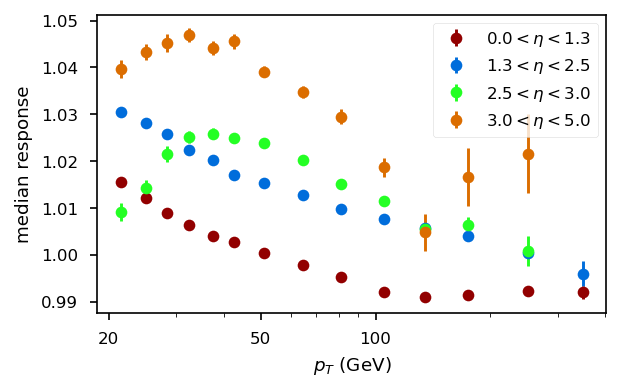

In [230]:
# load_fit_res=False
combine_antiflavour = False
subsamples = ['', '_b', '_c', '_u', '_d', '_s', '_g', '_bbar', '_cbar', '_ubar', '_dbar','_sbar']
# subsamples = ['_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Median", samp)
        meanvar = read_data("MedianVar", samp)
        median = read_data("Median", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        medians.append(median[0][0])
        medianstds.append(medianstd[0][0])
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            pass
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins or one_bin:
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(median, samp, medianstd)

-------------------------
-------------------------
Fitting subsample:  
Images will be saved under  fig/response_pt_eta_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  67 N_not_converge =  0


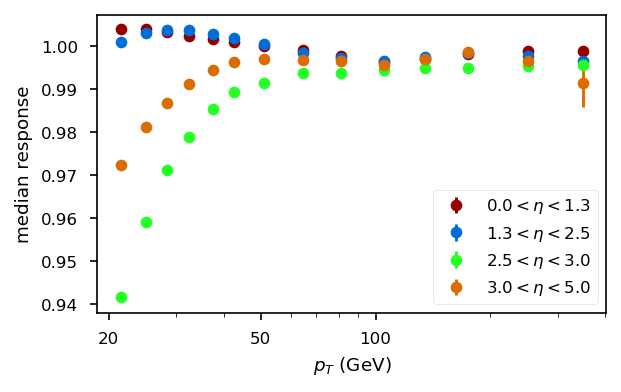

-------------------------
-------------------------
Fitting subsample:  _b
Images will be saved under  fig/response_pt_eta_b_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  62 N_not_converge =  0


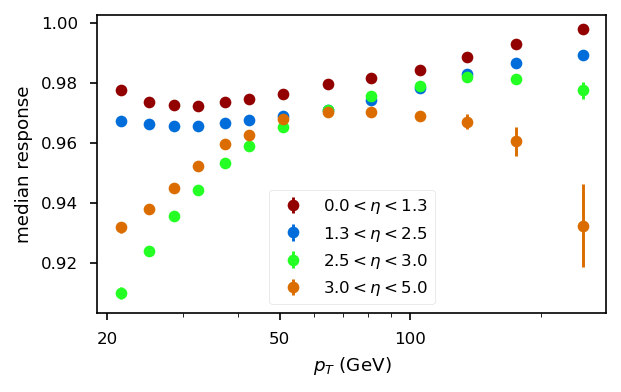

-------------------------
-------------------------
Fitting subsample:  _c
Images will be saved under  fig/response_pt_eta_c_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  60 N_not_converge =  0


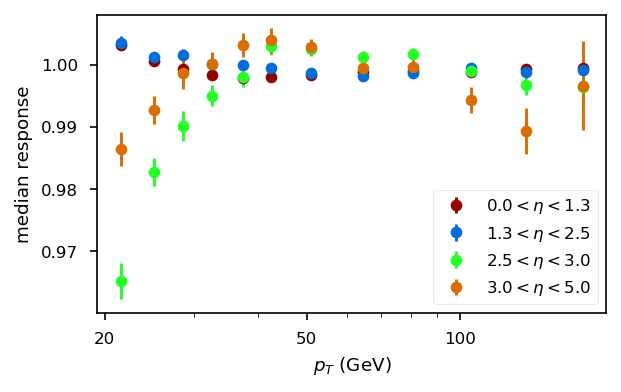

-------------------------
-------------------------
Fitting subsample:  _u
Images will be saved under  fig/response_pt_eta_u_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  64 N_not_converge =  0


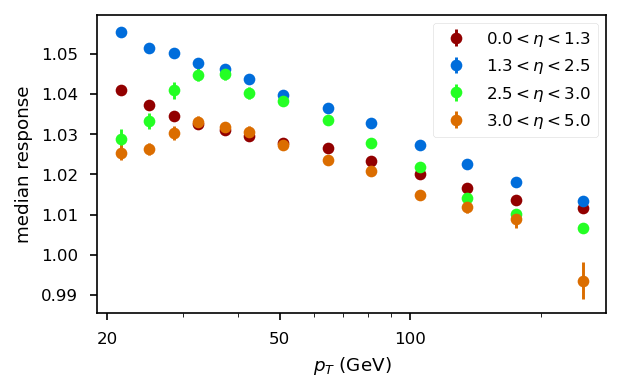

-------------------------
-------------------------
Fitting subsample:  _d
Images will be saved under  fig/response_pt_eta_d_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  66 N_not_converge =  0


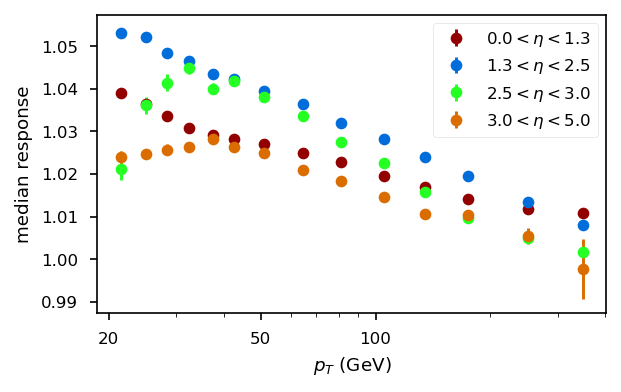

-------------------------
-------------------------
Fitting subsample:  _s
Images will be saved under  fig/response_pt_eta_s_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  61 N_not_converge =  0


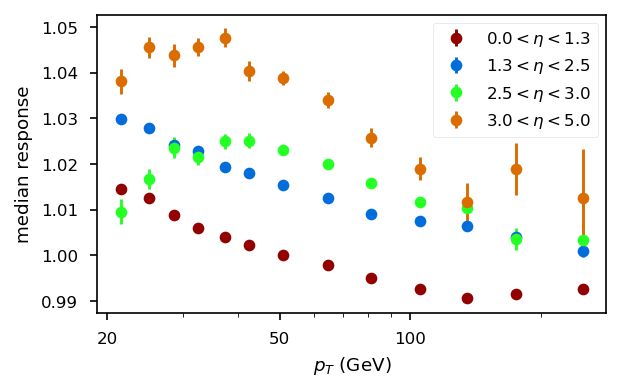

-------------------------
-------------------------
Fitting subsample:  _g
Images will be saved under  fig/response_pt_eta_g_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  63 N_not_converge =  0


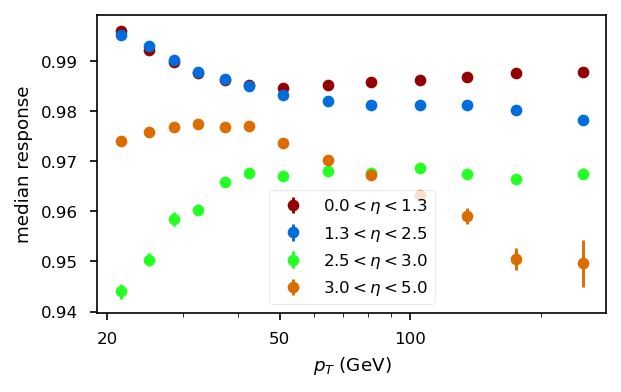

-------------------------
-------------------------
Fitting subsample:  _bbar
Images will be saved under  fig/response_pt_eta_bbar_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  62 N_not_converge =  0


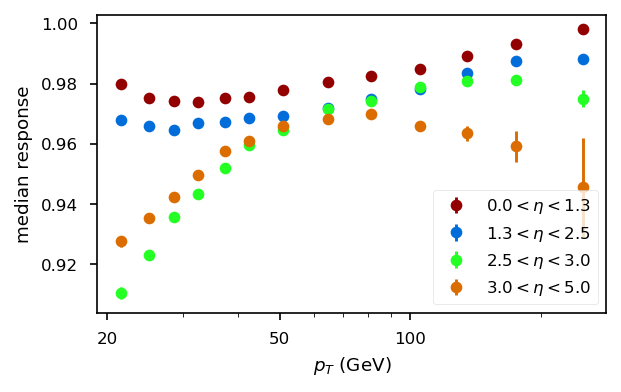

-------------------------
-------------------------
Fitting subsample:  _cbar
Images will be saved under  fig/response_pt_eta_cbar_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  60 N_not_converge =  0


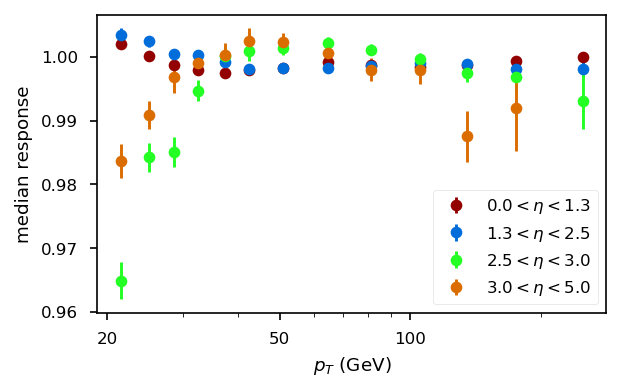

-------------------------
-------------------------
Fitting subsample:  _ubar
Images will be saved under  fig/response_pt_eta_ubar_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  62 N_not_converge =  0


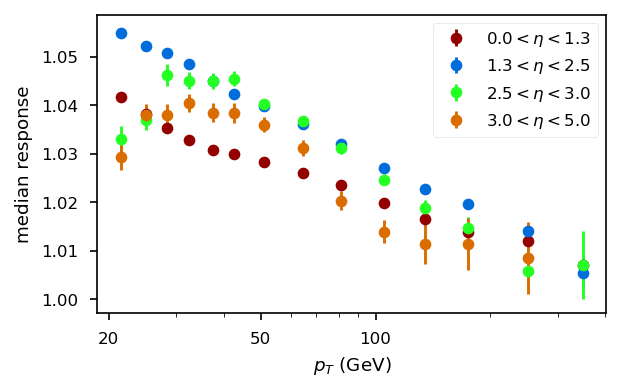

-------------------------
-------------------------
Fitting subsample:  _dbar
Images will be saved under  fig/response_pt_eta_dbar_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  60 N_not_converge =  0


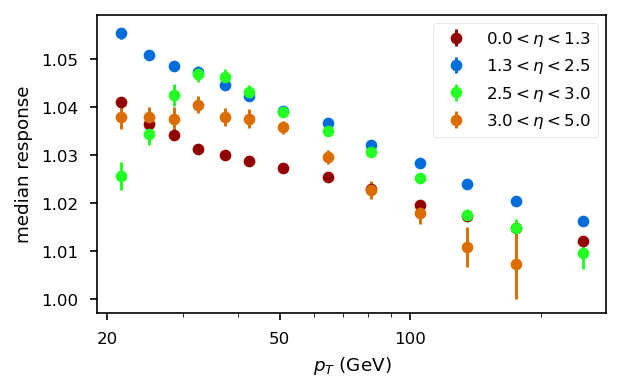

-------------------------
-------------------------
Fitting subsample:  _sbar
Images will be saved under  fig/response_pt_eta_sbar_L5_LHEflav1_Herwig-TTBAR-JME-100files
N converge =  60 N_not_converge =  0


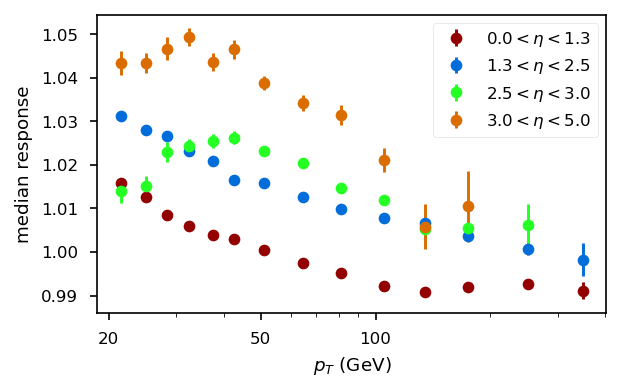

In [183]:
# load_fit_res=False
combine_antiflavour = False
subsamples = ['', '_b', '_c', '_u', '_d', '_s', '_g', '_bbar', '_cbar', '_ubar', '_dbar','_sbar']
# subsamples = ['_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Median", samp)
        meanvar = read_data("MedianVar", samp)
        median = read_data("Median", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        medians.append(median[0][0])
        medianstds.append(medianstd[0][0])
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            pass
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins or one_bin:
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(median, samp, medianstd)

In [ ]:
medianstds

In [ ]:
medians

In [ ]:
# load_fit_res=False
# combine_antiflavour = False
subsamples = ['', '_b', '_c', '_u', '_d', '_s', '_g', '_bbar', '_cbar', '_ubar', '_udbar','_sbar']
# subsamples = ['_b', '_c', '_ud', '_s', '_g']
# subsamples = ['', '_ud', '_g'] # , '_b']
for samp in subsamples:
    print('-'*25)
    print('-'*25)
    print('Fitting subsample: ', samp)
    if load_fit_res:
        mean = read_data("Median", samp)
        meanvar = read_data("MedianVar", samp)
        median = read_data("Median", samp)
        medianstd = read_data("MedianStd", samp)
#         width = read_data("Width")
#         median = read_data(median, "Median")
    else:
        mean, meanvar, median, medianstd = fit_responses(output, samp)
        medians.append(median[0][0])
        medianstds.append(medianstd[0][0])
        for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
            save_data(data, name, samp)
            pass
            
    meanstd = np.sqrt(meanvar)
            
    if fine_etabins or one_bin:
        plot_corrections_eta(median, samp, medianstd)
    else:
        plot_corrections(mean, samp, meanstd)

In [ ]:
mean

In [ ]:
# # load_fit_res=False
# subsamples = ['_b', '_c', '_ud', '_s', '_g', '_bbar', '_cbar', '_udbar', '_sbar']
# # subsamples = ['', '_ud', '_g'] # , '_b']
# for samp in subsamples:
#     print('-'*25)
#     print('-'*25)
#     print('Fitting subsample: ', samp)
#     if load_fit_res:
#         mean = read_data("Mean", samp)
#         meanvar = read_data("MeanVar", samp)
#         median = read_data("Mean", samp)
#         medianstd = read_data("MedianStd", samp)
# #         width = read_data("Width")
# #         median = read_data(median, "Median")
#     else:
#         mean, meanvar, median, medianstd = fit_responses(output, samp)
#         for data, name in zip([mean, meanvar, median, medianstd],["Mean", "MeanVar", "Median", "MedianStd"]):
#             save_data(data, name, samp)
            
#     meanstd = np.sqrt(meanvar)
            
#     if fine_etabins:
#         plot_corrections_eta(median, samp, medianstd)
#     else:
#         plot_corrections(mean, samp, meanstd)

### Fitting the mean responses

In [ ]:
samp = '_b'
etabin = 1

mean = read_data("Mean", samp)
meanvar = read_data("MeanVar", samp)

In [ ]:
means = mean[:, etabin]
means2fit = means[means!=0.0]
ptbins2fit = ptbins[:-1][means!=0.0]
meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [ ]:
import scipy as sp

In [ ]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [ ]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [ ]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    return p0+(p1/((np.log10(x)**2)+p2)) + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [ ]:
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],   
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    '':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    
}

Better starting fit values I found

In [ ]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [ ]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [ ]:
mean = read_data("Median", samp)[:,etabin]
read_data("Mean", samp)[:,etabin]
mean

In [ ]:
mean==numpy.float64
type(mean[2])

In [ ]:
# validpt_mask = np.isnan(mean)


### Fitting the mean responses

In [ ]:
my_mapping = {"": "aJ",
              "_b": "bT",
              "_c": "cT",
              "_s": "sT",
              "_g": "gT",
              "_ud": "qT"}

In [ ]:
import sympy 
from sympy import chebyshevt
  
x = sympy.symbols('x')

subsamples = ['','_b', '_c', '_u', '_d', '_g', '_s']
# subsamples = ['_b', '_c']


fit_res_all ={}
# etabins_all ={}
# nofpars_all ={}
for samp in subsamples:
    fit_res = []
    etabins_samp = []
    nofpars = []
    for etabin in range(4):
        mean = 1/read_data("Median", samp)[:,etabin]
        meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2

        start = np.searchsorted(ptbins_c, 20, side='left')
        mean_range = range(start-1, len(mean)-8)
        

#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
        means = mean[mean_range]
        ptbins2fit = ptbins_c[mean_range]
        validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))
        
        means2fit = means[validpt_mask]
        ptbins2fit = ptbins2fit[validpt_mask]
        meanvar2fit = np.abs(meanvar[mean_range][validpt_mask])
        
        
        fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
        fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])

        xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
        def sum_cheb(x, *p):
            return sum_cheb_tmp(x, ptbins2fit, *p)
        def sum_cheb5(x, *p):
            return sum_cheb5_tmp(x, ptbins2fit, *p)    
        def sum_cheb3(x, *p):
            return sum_cheb3_tmp(x, ptbins2fit, *p)  
        def sum_cheb2(x, *p):
            return sum_cheb2_tmp(x, ptbins2fit, *p)  
            
        try:
            p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
            p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=np.sqrt(meanvar2fit))
        except(RuntimeError):
            print("Winter 14 fit failed")
            p_resp, p_resp_err = [[np.nan]*6]*2
        #      = np.nan*6

        # p_resp_err
        p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
        p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=np.sqrt(meanvar2fit))
        p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
        p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=np.sqrt(meanvar2fit))
        p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
        p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=np.sqrt(meanvar2fit))
        p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
        p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=np.sqrt(meanvar2fit))
        
        expr = 0
        for ii in range(len(p_cheb3)):
            expr+=p_cheb3[ii]* chebyshevt(ii,x)
        poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)
#         len(poly_coefs)
        
#         etabins_samp = np.concatenate([etabins_samp,[etabins_mod[etabin], etabins_mod[etabin+1]]])
        fit_res = np.concatenate([fit_res,
                                  [etabins_mod[etabin], etabins_mod[etabin+1],
                                   len(p_cheb3), 
                                   fit_min_lim, fit_max_lim],
                                  p_cheb3 ])
        nofpars.append(len(p_cheb3))
        
        yvals_resp = response_fnc(xvals, *p_resp)
        yvals_resp_err = response_fnc(xvals, *p_resp_err)
        yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
        yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
        yvalsC3 = sum_cheb3(xvals, *p_cheb3)
        yvalsC2 = sum_cheb2(xvals, *p_cheb2)

        chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanvar2fit)
        chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanvar2fit)
        chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/np.abs(meanvar2fit))
        chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/np.abs(meanvar2fit))
        Ndof_C4 = len(ptbins2fit) - 5
        Ndof_C5 = len(ptbins2fit) - 6
        Ndof_C3 = len(ptbins2fit) - 4
        Ndof_C2 = len(ptbins2fit) - 3
        Ndof_resp = len(ptbins2fit) - 6


        fig, ax = plt.subplots()

        plt.errorbar(ptbins2fit, means2fit, yerr=np.sqrt(np.abs(meanvar2fit)), marker='o',
                     linestyle="none", label=f'Data {etabins_mod[etabin]}'+r'$<\eta<'+f'${etabins_mod[etabin+1]}')

        eta_string = '_eta'+str(etabins_mod[etabin])+'to'+str(etabins_mod[etabin+1])
        eta_string = eta_string.replace('.','')
        if np.isnan(chi2_resp): 
            winter14_lab = 'Winter14 func, failed'
        else:
            winter14_lab= 'Winter14 func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

        ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
        ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
        ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
        ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
    #     print("ynorm = ", y_norm)
    #     print("yerr = ", yerr_norm)
        std = np.sqrt(np.abs(meanvar2fit))
        norm_pos = (std<0.1) &  (std != np.inf)
    #     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

        ax.set_xlabel(r'$p_T$ (GeV)');
        ax.set_ylabel(r'mean response');
        ax.set_xscale('log')
        # ax.set_ylim([0.8,1.1])
        ax.legend(prop={'size': 7})
        if not test_run:
            plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        else:
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
            plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
        # fig.set_size_inches(6, 4, forward=True)
        plt.show();
        plt.close();
        
    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
    fit_res_all[my_mapping[samp]] = fit_res
#     etabins_all[my_mapping[samp]] = etabins_samp
#     nofpars_all[my_mapping[samp]] = nofpars
'a';

In [ ]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [ ]:
with open("Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4chs.txt", 'w') as file:
    file.write(header_txt+'\n')
    for key in fit_res_all.keys():
        file.write('['+key+']\n')
        file.write('{1 JetEta 1 JetPt ([0] + [1]*log10(x) + [2]*log10(x)*log10(x) + [3]*log10(x)*log10(x)*log10(x)) Correction L5Flavor}\n')
        for row in fit_res_all[key]:
            file.write('\t'.join([str(item) for item in row[:2]])+'\t'+str(int(row[2]))+'\t'+'\t'.join([str(item) for item in row[3:]])+'\n');

4; ## to suppress printouts of write

### Fit a specific $\eta$ $p_T$ bin

In [ ]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)
response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

In [ ]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [ ]:
samp=''

In [ ]:
etabins

In [ ]:
samp='_g'

In [ ]:
ptbins

In [ ]:
# histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(4.538,  4.716)).integrate('pt', hist.Interval(15, 40))
# histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-4.716, -4.538)).integrate('pt', hist.Interval(15, 40))

histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(0,  1.3)).integrate('pt', hist.Interval(23, 27))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-1.3, 0)).integrate('pt', hist.Interval(23, 27))
histo = (histoMi+histoPl)
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]

####################### Calculate median and rms ############################
yvals_cumsum = np.cumsum(yvals)
med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>0 else 0
median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                          - response_edges[med_bin])

hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
medianstd = 1.253 * hist_rms/np.sqrt(N)

####################### Fitting ############################
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2 or N<50:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1
             ######## Second Gaussian ########
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
        xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

        if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<6:
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        if xfit_l<0:
            xfit_h-=xfit_l
            xfit_l = 0
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
    except(RuntimeError):
        p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
        chi2 = np.nan
        arr = np.array([[np.nan]*3]*3)
        Ndof = 0
        N_not_converge += 1

fgaus2 = gauss(f_xvals, *p2)
histo = histo.rebin('ptresponse', plot_response_axis)
width_ik = np.abs(p2[2])




In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
print('-----'*10)
print("All done. Congrats!")